In [1]:
from fastai.basics import *
from fastai.vision.models.unet import *
from fastai.vision.all import *
from fastai.torch_basics import *
from denoising_diffusion_pytorch import Unet
from fastai.callback.wandb import _make_plt
from torch import autocast
from fastcore.transform import _is_tuple
from fastai.vision.gan import InvisibleTensor,generate_noise

We create two new Tensor Types, one for our noise, and one for our timestep. 

In [2]:
class TensorNoise(TensorImageBase):pass
class TensorStep(TensorBase): pass

We would like normalize to denormalize our noise before showing it. This is so the noise in our image looks similar to the noise in our noised image. 

In [3]:
@Normalize
def decodes(self, x:TensorNoise):
    f = to_cpu if x.device.type=='cpu' else noop
    return (x*f(self.std) + f(self.mean))

In [4]:
path = untar_data(URLs.IMAGENETTE_320)
img = Image.open(path.ls()[0].ls()[3].ls()[0])
norm = Normalize.from_stats(*imagenet_stats)
img = norm(TensorImage(image2tensor(img)[None]/255.).to(device='cuda'))

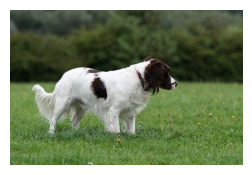

In [5]:
show_images(norm.decode(img))

Lets create a little function that denormalizes and shows our images. 

In [6]:
class ItemTransform(Transform):
    "A transform that always take tuples as items"
    _retain = True
    def __call__(self, x, **kwargs): return self._call1(x, '__call__', **kwargs)
    def decode(self, x, **kwargs):   return self._call1(x, 'decode', **kwargs)
    def _call1(self:ItemTransform, x, name, **kwargs):
        if not _is_tuple(x): return getattr(super(), name)(x, **kwargs)
        y=self._call_tuple(name,x,**kwargs)
        if not self._retain: return y
        if is_listy(y) and not isinstance(y, tuple): y = tuple(y)
        return retain_type(y, x)
    def _call_tuple(self, name, x, split_idx=None, **kwargs):
        f = getattr(super(), name)
        f2name='encodes' if name == '__call__' else 'decodes' if name == 'decode' else name
        f2 = getattr(self, f2name)
        if isinstance(f2,TypeDispatch) and f2[type(x)] is not None:
            if split_idx!=self.split_idx and self.split_idx is not None: return x
            y = f2(x, **kwargs)
        else:
            y = f(list(x), **kwargs)
        return y

The general idea is to implement a named tuple, and use duck typing. In the future, we should look at the named tuple class and do something more similar to that. 

In [7]:
class DiffusionTuple(fastuple):
    def __new__(cls, *rest):
        #bad code here, need to probably move to show_results?
        self=super().__new__(cls, *rest)
        i=0
        self.x=self[i]
        if(isinstance(self[i+1],TensorImage)): self.x0=self[i:=i+1]
        self.t=self[i:=i+1]
        if(len(self)>i+1): self.y=self[i:=i+1]
        if(len(self)>i+1): self.pred=self[i:=i+1]
        return self
    def show(self, ctx=None, show_noise=False,**kwargs): 
        line = self.x.new_zeros((*self.x.shape[:-1], 10)).long()
        imgs = []
        for im in self[:]: 
            if isinstance(im,TensorImage) or (isinstance(im,TensorNoise) and show_noise): 
                # must all be of same scale
                if im.dtype.is_floating_point: im=(im* 256).long() 
                imgs+=[line,TensorBase(im.clamp(0, 255))]
        imgs=torch.cat(imgs[1:], dim=self.x.ndim-1)
        
        if imgs.ndim>3: imgs=imgs[0]
        return show_image( imgs, title=self.t, ctx=ctx, **kwargs)

In [8]:
class ToDiffusionTuple(ItemTransform):
    order=100
    def encodes(self,xy):
        return DiffusionTuple(*xy[:-1],TensorNoise(xy[-1]))

In [9]:
class LabelToNoise(ItemTransform):
    order=101
    def encodes(self,xy:DiffusionTuple):
        y=xy.y
        xy.y[:]=TensorNoise(torch.randn_like(y))
        return xy

In [10]:
diff_tuple=LabelToNoise.encodes(DiffusionTuple(img[0].detach().clone(),TensorStep(torch.tensor([[200]])),TensorNoise(img[0].clone())))

In [11]:
norm.decode(diff_tuple)[0].max()

TensorImage(1., device='cuda:0')

<AxesSubplot:title={'center':'TensorStep([[200]])'}>

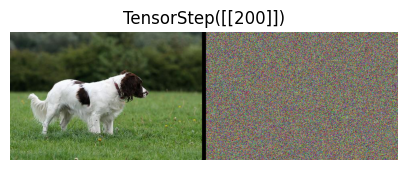

In [12]:
norm.decode(diff_tuple).show(show_noise=True)

In [13]:
class Diffusion_P_Sampler():
    def __init__(self,model,sampling_function):
        self.device=sampling_function.device
        self.model=model
        self.sampling_function=sampling_function
    def __call__(self,x,ts=None):
        ts=(self.sampling_function.n_steps-1)*torch.ones([x.shape[0],1],device=x.device) if ts is None else ts.flatten()
        for xt in self.iter_noise(x,TensorBase(ts)): x=xt
        return x
    def iter_noise(self,x_t,ts):
        while((ts>0).any()):
            x,t=x_t[ts>0],ts[ts>0]
            with autocast(device_type=self.device, dtype=x.dtype):
                with torch.no_grad(): 
                    e = self.model(x,t)
                x_t[ts>0]=self.sampling_function(x,e,t)
            ts[ts>0]-=1
            yield x_t

In [14]:
class LinearNoiseSchedule:
    "Schedule like used in DDPM"
    def __init__(self,betas=None,n_steps=None,device='cuda'):
        if betas is not None: self.n_steps=betas.shape[0]
        if n_steps is None: self.n_steps=1000
        if betas is None: self.betas = torch.linspace(0.0001, 0.02, self.n_steps,device=device)
        self.alphas = 1. - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)

In [15]:
class DDPM_Q_Sampling():
    def __init__(self,predicts_x=False,noise_schedule=LinearNoiseSchedule(),n_steps=1000,device='cuda'):
        self.device=device
        self.ns=noise_schedule
        self.n_steps=n_steps
        self.t_sched=torch.linspace(0,len(self.ns.alpha_bar)-1,n_steps,dtype=torch.long)[...,None,None,None]
    def __call__(self,x,es,t):
        t=self.t_sched[t]
        a=self.ns.alpha_bar[t].to(device=x.device)
        signal = (a ** .5)*x
        noise = (1-a)**.5 * es
        return signal + noise

In [16]:
class DDPM_P_Sampling():
    def __init__(self,predicts_x=False,noise_schedule=LinearNoiseSchedule(),n_steps=1000,device='cuda'):
        self.device=device
        self.ns=noise_schedule
        self.n_steps=n_steps
        self.t_sched=torch.linspace(0,len(self.ns.alpha_bar)-1,n_steps,dtype=torch.long)[...,None,None,None]
        if(predicts_x): raise NotImplementedError()
    def __call__(self,x,es,t):
        t=self.t_sched[t]
        n=torch.randn_like(x)
        e,a,b=self._noise_at_t(es,t),self.ns.alphas[t],self.ns.betas[t]
        signal = (x - e) / (a ** 0.5)
        noise = b**.5 * n
        return signal + noise
    def _noise_at_t(self,es,t):
        eps_coef = (1 - self.ns.alphas[t]) / (1 - self.ns.alpha_bar[t]) ** .5 
        return eps_coef* es

In [17]:
class DDIM_P_Sampling():
    def __init__(self,predicts_x=False,n_steps=50,noise_schedule=LinearNoiseSchedule(),device='cuda'):
        self.predicts_x=predicts_x
        self.device=device
        self.ns=noise_schedule
        self.n_steps=n_steps
        self.t_sched=torch.linspace(0,self.ns.n_steps-1,n_steps,dtype=torch.long)
    def __call__(self,z,es,ns_t):
        t=self.t_sched[ns_t*(self.n_steps-1)//self.ns.n_steps]
        tp1=self.t_sched[ns_t*self.n_steps//self.ns.n_steps]
        a,a_tp1=self.ns.alpha_bar[t][...,None,None,None],self.ns.alpha_bar[tp1][...,None,None,None]
        if self.predicts_x: 
            xs=es
            es=(z - (a)**.5 * xs)/(1-a)**.5
        else: xs=(z - (1-a)**.5 * es)/ (a ** .5)
        signal = a_tp1**.5*(xs) 
        noise = (1-a_tp1)**.5*es
        return signal + noise

In [18]:
class DiffusionSamplingTransform(ItemTransform):
    order=101
    "noise_sampler, or q_sampler, goes to noise at t=T. image sampler, p_sampler, goes to image at t=0"
    def __init__(self,noise_sampler,image_sampler):
        self.q_sample=noise_sampler
        self.p_sample=image_sampler
    def encodes(self,xy:DiffusionTuple):
        y=xy.y
        ts = xy.t[:,0]
        x_type=type(xy.x)
        x=self.q_sample(xy.x, TensorBase(xy.y),x_type(ts),)
        xy.x[:]=x[:]
        return xy
    def decodes(self,xy:DiffusionTuple):
        ts = type(xy.x)(xy.t)
        xy.y[:] = TensorNoise(self.p_sample(xy.x.clone().detach().cuda(),xy.t.clone().detach().cuda()))[:]
        return xy

In [19]:
diff_trans = DiffusionSamplingTransform(DDPM_Q_Sampling(),Diffusion_P_Sampler(lambda x:x,DDPM_P_Sampling()))

<AxesSubplot:title={'center':'TensorStep([[200]])'}>

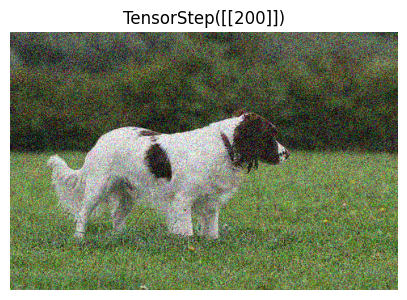

In [20]:
norm.decode(diff_trans(diff_tuple)).show()

Lets now test so make sure our noise is being generated correctly.

In [21]:
noise_tuple=LabelToNoise.encodes(DiffusionTuple(img[0].detach().clone(),TensorStep(torch.tensor([[999]])),TensorNoise(img[0].clone())))

<AxesSubplot:title={'center':'TensorStep([[999]])'}>

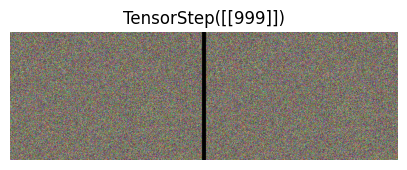

In [22]:
norm.decode(diff_trans(noise_tuple)).show(show_noise=True)

These are not exactly the same as it is one noising step, but they are fairly close. 

In [23]:
is_close(norm.decode(diff_trans(noise_tuple))[0],TensorImage(norm.decode(diff_trans(noise_tuple))[2]),eps=1e-02)

TensorImage(True, device='cuda:0')

### Training a model

In [24]:
path = untar_data(URLs.CIFAR)

In [25]:
m=Unet(dim=192+192//8,channels=3,).cuda()

In [26]:
@typedispatch
def show_batch(x:DiffusionTuple, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(3*min(len(x[0]), max_n), nrows=nrows, ncols=3, figsize=figsize, title='Input/Original/Target')
    for i,ctx in enumerate(ctxs): DiffusionTuple(x[0][i], x[1][i], x[2][i].item(),x[3][i]).show(ctx=ctx)

@typedispatch
def show_batch(x:DiffusionTuple, y, samples, ctxs=None, max_n=10, nrows=None, ncols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(3*min(len(samples), max_n), nrows=nrows, ncols=3, figsize=figsize, title='Input/Original/Target')
    ctxs[0::3] = [b.show(ctx=c, **kwargs) 
                  for b,c,_ in zip(samples.itemgot(0),ctxs[0::3],range(max_n))]
    ctxs[0::3] = [b.show(ctx=c, **kwargs) 
                  for b,c,_ in zip(samples.itemgot(2),ctxs[0::3],range(max_n))]
    ctxs[1::3] = [b.show(ctx=c, **kwargs) 
                  for b,c,_ in zip(samples.itemgot(1),ctxs[1::3],range(max_n))]
    ctxs[2::3] = [b.show(ctx=c, **kwargs) 
                  for b,c,_ in zip(samples.itemgot(3),ctxs[2::3],range(max_n))]
    return ctxs

This callback is used specifically to get lucidrain's model to work with our dataloader. 

In [27]:
class FlattenCallback(Callback):
    order=1 #after GatherPredsCallback
    #Maybe done for specific model? 
    def before_batch(self):
        self.xbo=self.xb
        self.learn.xb=(self.xb[0],self.xb[-1].view(self.xb[-1].shape[::2]),)
    def after_batch(self):
        self.learn.xb=self.xbo

In [28]:
@typedispatch
def show_results(x:DiffusionTuple, y, samples, outs, ctxs=None, max_n=10, figsize=None,**kwargs):
    if ctxs is None: ctxs = get_grid(min(len(x[0]), max_n), ncols=4, figsize=figsize, title='Input/Original/DenoisedImage')
    for i,ctx in enumerate(ctxs): 
        DiffusionTuple(x[0][i], x[1][i], x[2][i].item(),x[3][i],TensorImage(y[-1][i]),
                      ).show(ctx=ctx,**kwargs)
    #ctxs[0::3] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(0),ctxs[0::3],range(max_n))]
    #ctxs[1::3] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(1),ctxs[1::3],range(max_n))]
    #ctxs[0::3] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(2),ctxs[0::3],range(max_n))]
    #for i,ctx in enumerate(ctxs[1::2]): 
    #ctxs[1::3] = [o.show(ctx=c, **kwargs) for o,c,_ in zip(y.itemgot(0),ctxs[2::3],range(max_n))]
    return ctxs

In [29]:
@typedispatch
def show_batch(x:DiffusionTuple, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(3*min(len(x[0]), max_n), nrows=nrows, ncols=3, figsize=figsize, title='Input/Original/Target')
    for i,ctx in enumerate(ctxs): DiffusionTuple(x[0][i], x[1][i], x[2][i].item(),x[3][i]).show(ctx=ctx)

In [30]:
def DiffusionNoiseBlock(cls:PILBase=PILImage):
    "A `TransformBlock` for images of `cls`"
    return TransformBlock(type_tfms=cls.create)

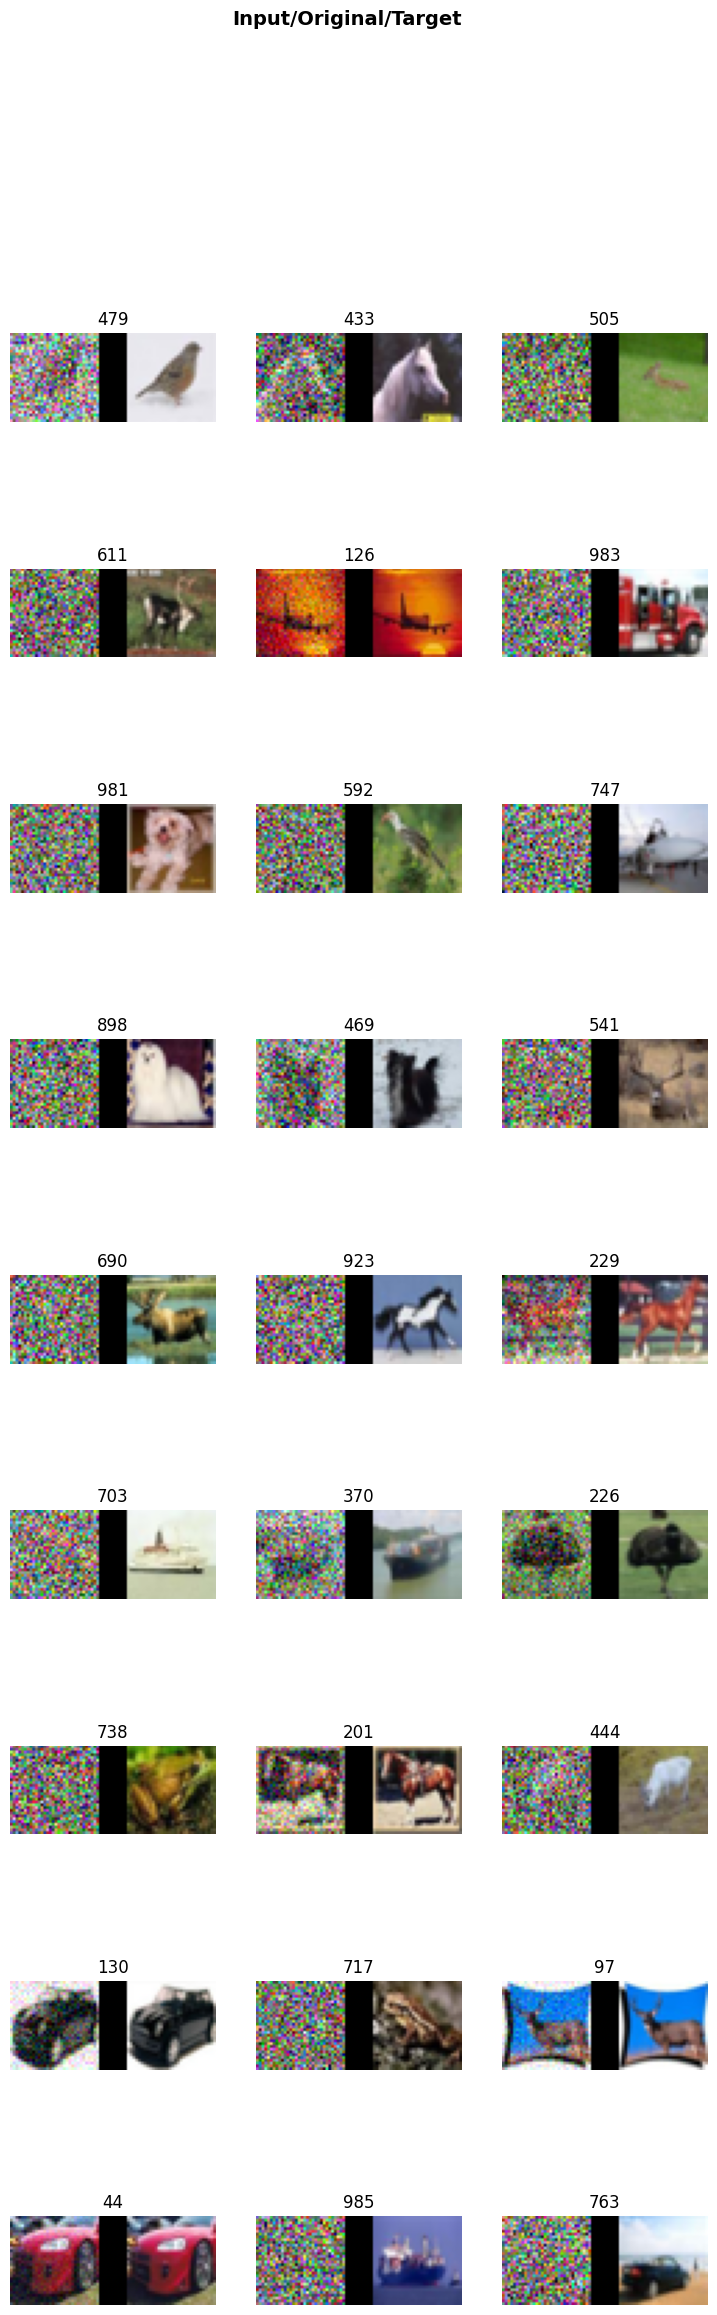

In [31]:
bs=128
n_steps=1000
diffusion_transform = DiffusionSamplingTransform(DDPM_Q_Sampling(),Diffusion_P_Sampler(m,DDPM_P_Sampling()))
dls=DataBlock((ImageBlock(),
               ImageBlock(),
               TransformBlock(type_tfms=[DisplayedTransform(enc=lambda o: TensorStep(o))]),
               ImageBlock()),
          n_inp=3,
          item_tfms=[Resize(32)],
          batch_tfms=(Normalize.from_stats(*cifar_stats),ToDiffusionTuple,LabelToNoise,diffusion_transform),
          get_items=get_image_files,
          get_x=[lambda x:x,lambda x:x,
                 lambda x: torch.randint(0, n_steps, (1,), dtype=torch.long)],
          splitter=IndexSplitter(range(bs)),
).dataloaders(path,bs=bs,val_bs=2*bs)
dls.show_batch()

In [32]:
def mse_loss_weighted(ys,targ):
    return torch.mean(targ.w_sched[...,None] * ((ys - targ).flatten(start_dim=1) ** 2))

In [33]:
#| echo: true
def snr(at): return at/(1-at)

In [34]:
def continuous_weights(at):
    weights = -snr(at[1:])/(snr(at[1:])-snr(at[:-1]))
    return torch.cat((weights[0:1],weights))

In [35]:
class WeightedLinSched(Callback):
    def after_pred(self):
        if(not hasattr(self,'ws')):
            self.ws = continuous_weights(LinearNoiseSchedule().alpha_bar).clip(min=1)
            self.ws /= self.ws.mean()
        ts=self.learn.xb[1].flatten()
        self.learn.yb[0].w_sched=self.ws[ts]

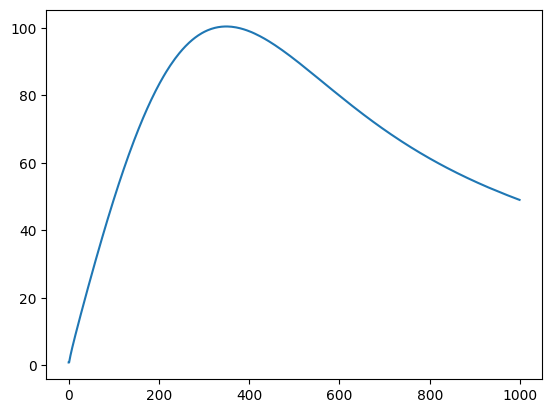

In [36]:
plt.plot(continuous_weights(LinearNoiseSchedule().alpha_bar.cpu()))

In [37]:
learn = Learner(dls,m,mse_loss_weighted,opt_func=Adam,cbs=[FlattenCallback,WeightedLinSched])
learn = learn.to_fp16()
learn.fit_flat_cos(10,lr=2e-4,wd=0.)

epoch,train_loss,valid_loss,time
0,0.049789,0.042322,04:39
1,0.044212,0.039284,04:39
2,0.041315,0.045253,04:40
3,0.040457,0.038427,04:39
4,0.039394,0.035517,04:40
5,0.039198,0.039416,04:39
6,0.039298,0.037537,04:39
7,0.038256,0.040432,04:39
8,0.038232,0.025152,04:40
9,nan,0.036510,04:38


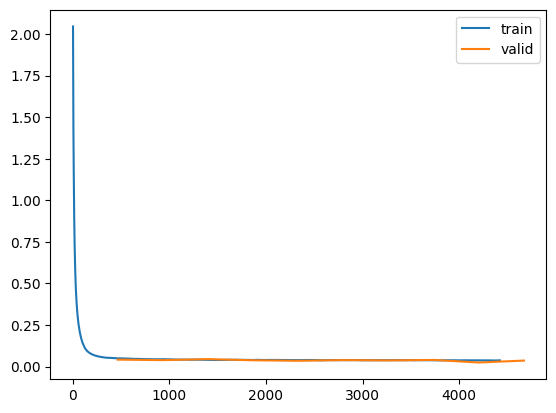

In [38]:
learn.recorder.plot_loss()

In [39]:
learn.dls=dls

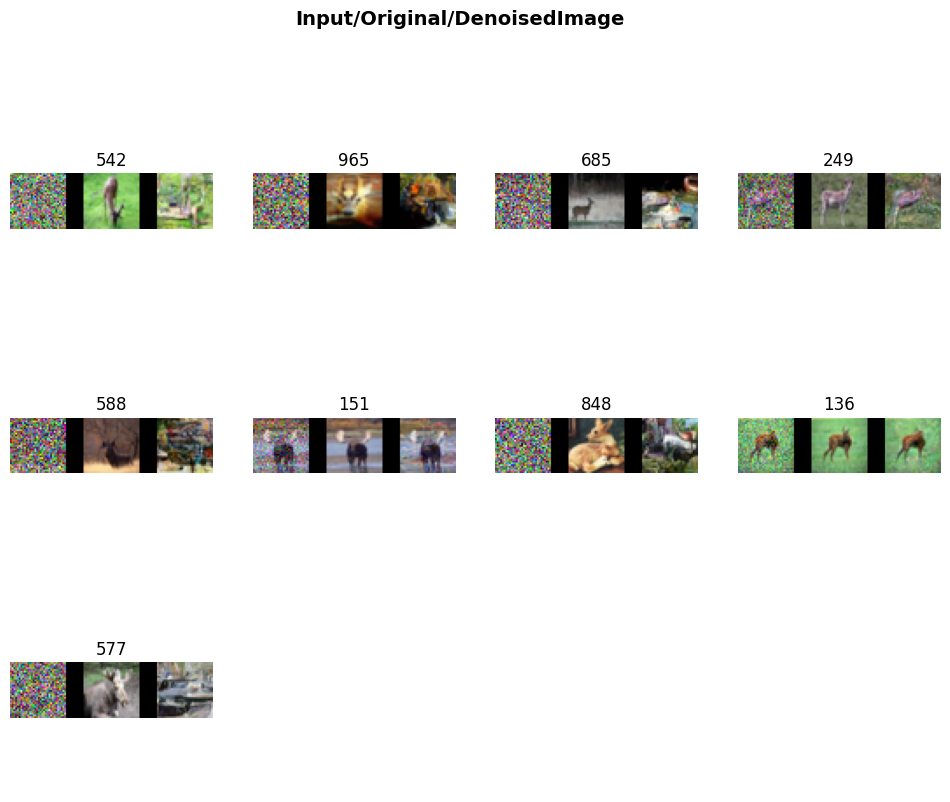

In [40]:
#import pdb;pdb.set_trace()
learn.show_results()

next check show_results